In [142]:
import pandas as pd
import numpy as np
from brfinance import CVMAsyncBackend
cvm_httpclient = CVMAsyncBackend()
from datetime import datetime, date
import json
import os
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm 
from pandas_datareader import data as web
import matplotlib.pyplot as plt

In [162]:
class Financials_Statements:
    
    def __init__(self, cod_cvm, start_date):
        self.cod_cvm = [str(cod_cvm)]
        self.start_date = start_date
        self.search_dfp = cvm_httpclient.get_consulta_externa_cvm_results(start_date= self.start_date, cod_cvm = self.cod_cvm, category=["EST_4"])
        self.search_dfp = self.search_dfp.loc[self.search_dfp["status"] == "Ativo"]
        self.search_itr = cvm_httpclient.get_consulta_externa_cvm_results(start_date= self.start_date, cod_cvm = self.cod_cvm, category=["EST_3"])
        self.search_itr = self.search_itr.loc[self.search_itr["status"] == "Ativo"]
        self.nome = self.search_itr["empresa"][0]
        self.numero_seq_documento_itr = self.search_itr[["numero_seq_documento", "ref_date"]]
        self.numero_seq_documento_dfp = self.search_dfp[["numero_seq_documento", "ref_date"]]
        self.append_balance_assets = []
    
    def balance_sheet_assets(self, date, period):
        if period == "itr":
            number = self.numero_seq_documento_itr.loc[self.numero_seq_documento_itr["ref_date"] == date].iloc[0,0]
        else:
            number = self.numero_seq_documento_dfp.loc[self.numero_seq_documento_dfp["ref_date"] == date].iloc[0,0]
        balance = cvm_httpclient.get_report(number, 1, ["Balanço Patrimonial Ativo"])
        return balance.get("Balanço Patrimonial Ativo").fillna(0)
    
    def balance_sheet_liabilities(self, date, period):
        if period == "itr":
            number = self.numero_seq_documento_itr.loc[self.numero_seq_documento_itr["ref_date"] == date].iloc[0,0]
        else:
            number = self.numero_seq_documento_dfp.loc[self.numero_seq_documento_dfp["ref_date"] == date].iloc[0,0]
        balance = cvm_httpclient.get_report(number, 1, ["Balanço Patrimonial Passivo"])
        return balance.get("Balanço Patrimonial Passivo").fillna(0)
    
    def dfc(self, date, period):
        if period == "itr":
            number = self.numero_seq_documento_itr.loc[self.numero_seq_documento_itr["ref_date"] == date].iloc[0,0]
        else:
            number = self.numero_seq_documento_dfp.loc[self.numero_seq_documento_dfp["ref_date"] == date].iloc[0,0]
        balance = cvm_httpclient.get_report(number, 1, ["Demonstração do Fluxo de Caixa"])
        return balance.get("Demonstração do Fluxo de Caixa").fillna(0)
    
    
    def income_statement(self, date, period):
        if period == "itr":
            number = self.numero_seq_documento_itr.loc[self.numero_seq_documento_itr["ref_date"] == date].iloc[0,0]
        else:
            number = self.numero_seq_documento_dfp.loc[self.numero_seq_documento_dfp["ref_date"] == date].iloc[0,0]
        balance = cvm_httpclient.get_report(number, 1, ["Demonstração do Resultado"])
        return balance.get("Demonstração do Resultado").fillna(0)
    
    def income_acum(self, account, types, report):
        append_revenue = []
        if types == "itr":
            d = self.numero_seq_documento_itr
        else:
            d = self.numero_seq_documento_dfp
        if report == 1:
            rep = self.balance_sheet_assets
        if report == 2:
            rep = self.balance_sheet_liabilities
        if report == 3:
            rep = self.income_statement
        for x in d["ref_date"]:
            r = rep(x, types).loc[rep(x, types)["Descrição"] == account].iloc[0,2]
            append_revenue.append({account:r, "Data": x })
        data = pd.json_normalize(append_revenue).iloc[::-1].reset_index(drop = True)
        data = data.set_index("Data")
        return data

In [124]:
class Price:
    
    def __init__(self, symbols, start, end, adjust_price):
        self.symbols = symbols
        self.start = start
        self.end = end
        self.adjust_price = adjust_price
        self.historical_prices = web.get_data_yahoo( self.symbols,
                                                 self.start,
                                                 self.end,
                                                 self.adjust_price )
        self.high = self.historical_prices["High"]
        self.low = self.historical_prices["Low"]
        self.open = self.historical_prices["Open"]
        self.close = self.historical_prices["Close"]
        self.volume = self.historical_prices["Volume"]
        self.adjclose = self.historical_prices["Adj Close"]

class Operação:
    
    def __init__(self, preco, qtd, data, ticker, tipo):
        self.preco_de_compra = preco
        self.qtd = qtd
        self.data_de_compra = data
        self.tipo = tipo
        if self.tipo =="V":
            self.qtd = self.qtd * -1
        self.dict = {'Ticker': ticker, 'Price': preco , 'Quantidade': self.qtd , 'Data': data, 'Tipo': tipo, 'Financeiro': preco * self.qtd}
        self.df = pd.DataFrame.from_dict(self.dict, orient = "index").T
        self.save  = self.df.to_csv("Operações\\"+ticker+" - "+data )

class Portfolio:
    
    def consolidar(self):
        df = []
        for x in os.listdir("Operações")[1:]:
            data = pd.read_csv("Operações\\"+x)
            df.append(data)
        return pd.concat(df)
        
    def __init__(self):
        self.nav = "R$  " + str(self.consolidar()["Financeiro"].sum())
        
        
class Erk:
    
    def drawdown(return_series: pd.Series):
        """
        Takes a times series of assests returns
        Computes and returns a DataFrame that contains:
        the wealth index
        the previous peaks
        percent drawdowns
        """
        wealth_index = 1000*(1+return_series).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks)/previous_peaks
        return pd.DataFrame({
            "Wealth":wealth_index,
            "Peaks":previous_peaks,
            "Drawdown": drawdowns})

    def skewness(r):
        """
        função alternativa a scipy.stats.skew()
        calcula o skewness de uma série ou dataframe
        retorna um float ou series
        """
        demeaned_r = r - r.mean()
        # use o desvio-padrão populacional
        sigma_r = r.std(ddof=0)
        exp = (demeaned_r**3).mean()
        return exp/sigma_r**3

    def kourtosis(r):
        """
        função alternativa a scipy.stats.kourtosis()
        calcula o skewness de uma série ou dataframe
        retorna um float ou series
        """
        demeaned_r = r - r.mean()
        # use o desvio-padrão populacional
        sigma_r = r.std(ddof=0)
        exp = (demeaned_r**4).mean()
        return exp/sigma_r**4
    
    def is_normal(r, level=0.01):
        """
        Aplica o teste jarque-bera para determinar se uma série é normalmente distribuida ou não
        teste aplicado com 99% de confiança
        Retorna verdadeiro caso seja normalmente distribuído, caso contrário falso
        """
        statistics, p_value = scipy.stats.jarque_bera(r)
        print(scipy.stats.jarque_bera(r))
        return p_value > level

    def semideviation(r):
        """
        Retorna o desvio dos valores negativos de uma série ou data frame
        """
        r = r.fillna(0)
        return r[r<0].std(ddof=0)

    def var_historic(r, level=5):
        """
        VaR histórico
        """
        if isinstance(r, pd.DataFrame):
            return r.aggregate(var_historic, level=level)
        elif isinstance(r, pd.Series):
            return -np.percentile(r, level)
        else:
            raise TypeError("Valor esperado: DataFrame ou Series")
            
    def var_gaussian(r, level=5, modified=False):
        """
        Retorna o VaR gaussiano de uma série ou dataframe 
        """
        # cálculo do z-score
        z = norm.ppf(level/100)
        if modified:
            # modifica o z-score com base no kourtosis e skewness
            s = skewness(r)
            k = kourtosis(r)
            z = (z +
                    (z**2 - 1)*s/6 + 
                    (z**3 -3*z)*(k-3)/24 -
                    (2*z**3 - 5*z)*(s**2)/36
                )
        return -(r.mean() + z * r.std(ddof=0))
    
    def annualize_rets(r, periods_per_year):
        """
        retorna o retorno composto por perídos no ano de um dataframe
        """
        compounded_growth = (1+r).prod()
        n_periods = r.shape[0]
        return compounded_growth**(periods_per_year/n_periods)-1

    def annualize_vol(r, periods_per_year):
        """
        Anualiza a volatilidade de retornos inferindo períodos por ano
        """
        return r.std()*(periods_per_year**0.5)


    
class Indic:
    
    def __init__(self, ticker):
        
        import fundament as f
        
        self.ticker = ticker
        self.indicators = pd.DataFrame.from_dict(f.get_data())[self.ticker]

In [81]:
class Finance:
    
    def Beta(cov_with_market, market_var):
        return cov_with_market / market_var
    
    def CAPM(r, cov_r, cov_with_market, market_var, rf, k):
        beta = Finance.Beta(cov_with_market, market_var)
        return rf + beta * k
    
    def regression(X, Y):
        X1 = sm.add_constant(X)
        reg = sm.OLS(Y, X1).fit()
        return reg.summary()
    
    def d1(S, K, r, stdev, T):
        return (np.log(S/K) + (r + stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))
    
    def d2(S, K, r, stdev, T):
        return (np.log(S/K) + (r - stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))    
    
    def BSM(S, K, r, stdev, T):
        return (S * norm.cdf(Finance.d1(S, K, r, stdev, T))) - (K * np.exp(-r * T) * norm.cdf(Finance.d2(S, K, r, stdev, T)))
    
    def euler(T, t_intervals, iterations, S0, r, stdev):
        delta_t = T / t_intervals
        Z = np.random.standard_normal((t_intervals + 1, iterations))
        S = np.zeros_like(Z)
        S[0] = S0
        for t in range(1, t_intervals + 1):
            S[t] = S[t-1] * np.exp((r - 0.5 * stdev ** 2) * delta_t + stdev * delta_t ** 0.5 * Z[t])
        return S

# Preços Históricos

In [12]:
historical_prices = Price(["PETR3.SA", "^BVSP"], None, None, True)

In [51]:
historical_prices.adjclose.tail()

Symbols,PETR3.SA,^BVSP
Date,,
2022-01-25,35.799999,109845.000000
2022-01-26,36.849998,111573.000000
2022-01-27,36.990002,112315.000000
2022-01-28,35.490002,111478.000000
2022-01-31,35.360001,112093.117188


# Beta 

In [137]:
{"PETR3 Beta" : Finance.Beta(historical_prices.adjclose.pct_change().cov().iloc[0,1], historical_prices.adjclose["^BVSP"].pct_change().var())}

{'PETR3 Beta': 1.4027836271575829}

# Capital Asset Pricing Model

In [138]:
{"PETR3 CAPM" :Finance.CAPM(historical_prices.adjclose["PETR3.SA"].pct_change(),historical_prices.adjclose.pct_change().cov().iloc[0,0],historical_prices.adjclose.pct_change().cov().iloc[0,1],
            historical_prices.adjclose["^BVSP"].pct_change().var(), 0.095, historical_prices.adjclose["^BVSP"].pct_change().mean() ) }

{'PETR3 CAPM': 0.09582073253583316}

# Regressão Multivariada

In [40]:
Finance.regression( np.array(list(range(1, 10))), np.array(list(range(11 , 20)) ) )

C:\Users\gabri\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.218e+31
Date:                Mon, 31 Jan 2022   Prob (F-statistic):          5.14e-108
Time:                        17:22:28   Log-Likelihood:                 294.73
No. Observations:                   9   AIC:                            -585.5
Df Residuals:                       7   BIC:                            -585.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0000   1.19e-15   8.37e+15      0.000      10.000      10.000
x1             1.0000   2.12e-16   4.71e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        5.517   Durbin-Watson:                   0.333
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                2.310
Skew:                          -1.238   Prob(JB):                        0.315
Kurtosis:                       3.170   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Black - Scholes - Merton

In [112]:
BSM = Finance.BSM(historical_prices.adjclose["PETR3.SA"][-1], 31.51, Erk.annualize_rets(historical_prices.adjclose["PETR3.SA"].pct_change(), len(historical_prices.adjclose["PETR3.SA"])),
            Erk.annualize_vol(historical_prices.adjclose["PETR3.SA"].pct_change(), len(historical_prices.adjclose["PETR3.SA"])), 1)

In [123]:
print({"BSM PETR3" : BSM} )

{'BSM PETR3': 30.634205814899534}


In [85]:
S = Finance.euler(1.0, len(historical_prices.adjclose), 1000, historical_prices.adjclose["PETR3.SA"][-1], 0.0925, 
              Erk.annualize_vol(historical_prices.adjclose["PETR3.SA"].pct_change(), len(historical_prices.adjclose["PETR3.SA"])))

# Plotando caminhos aleatórios

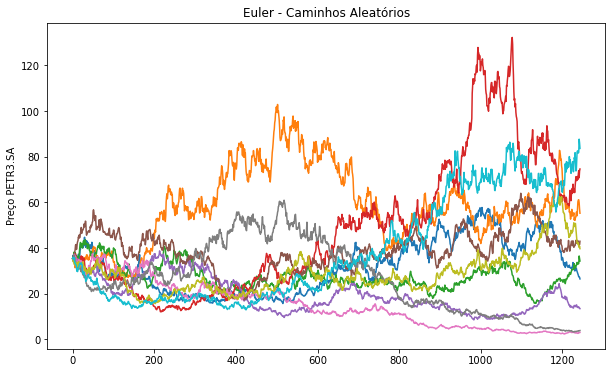

In [101]:
plt.figure(figsize=(10, 6))
plt.ylabel("Preço PETR3.SA")
plt.title("Euler - Caminhos Aleatórios")
plt.plot(S[:,:10]);

# Retorno anualizado

In [107]:
pd.DataFrame({"Retorno Annualizado Decimal" : Erk.annualize_rets(historical_prices.adjclose.pct_change(), len(historical_prices.adjclose))})

,Retorno Annualizado Decimal
Symbols,
PETR3.SA,1.866277
^BVSP,0.728872


# Volatilidade Anualizada

In [108]:
pd.DataFrame({"Vol Anualizada Decimal": Erk.annualize_vol(historical_prices.adjclose.pct_change(), len(historical_prices.adjclose))})

,Vol Anualizada Decimal
Symbols,
PETR3.SA,1.059132
^BVSP,0.594620


# Drawdown

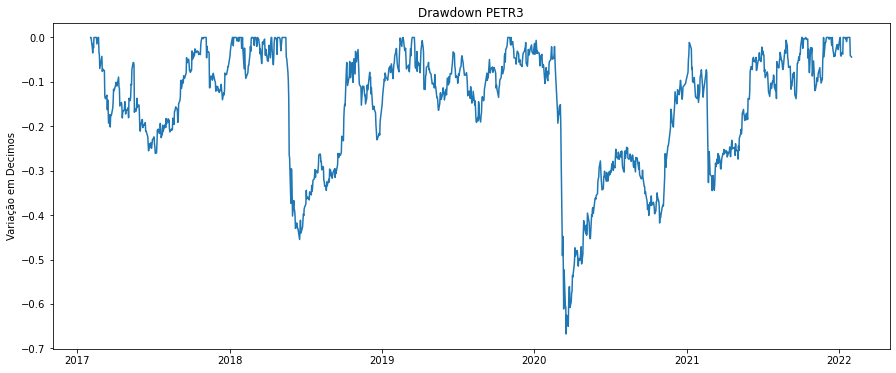

In [136]:
plt.figure(figsize=(15, 6))
plt.ylabel("Variação em Decimos")
plt.title("Drawdown PETR3")
plt.plot(Erk.drawdown(historical_prices.adjclose["PETR3.SA"].pct_change())["Drawdown"]);

# Wealth Index

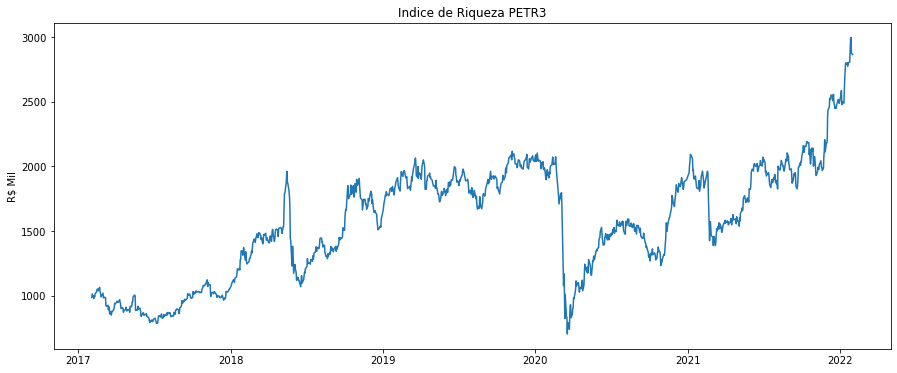

In [140]:
plt.figure(figsize=(15, 6))
plt.ylabel("R$ Mil")
plt.title("Indice de Riqueza PETR3")
plt.plot(Erk.drawdown(historical_prices.adjclose["PETR3.SA"].pct_change())["Wealth"]);

# Verificando se os Preços seguem uma Distribuição Normal

In [145]:
{"Resultado" : Erk.is_normal(historical_prices.adjclose.pct_change())}

Jarque_beraResult(statistic=nan, pvalue=nan)


{'Resultado': False}

# Verificando o Kourtosis

In [148]:
{"Kurtosis" : Erk.kourtosis(historical_prices.adjclose.pct_change())}

{'Kurtosis': Symbols
 PETR3.SA    20.540567
 ^BVSP       20.176762
 dtype: float64}

# Verificando Skeness - Preço

In [153]:
{"Skewness" : Erk.skewness(historical_prices.adjclose.pct_change())}

{'Skewness': Symbols
 PETR3.SA   -1.245365
 ^BVSP      -1.086694
 dtype: float64}

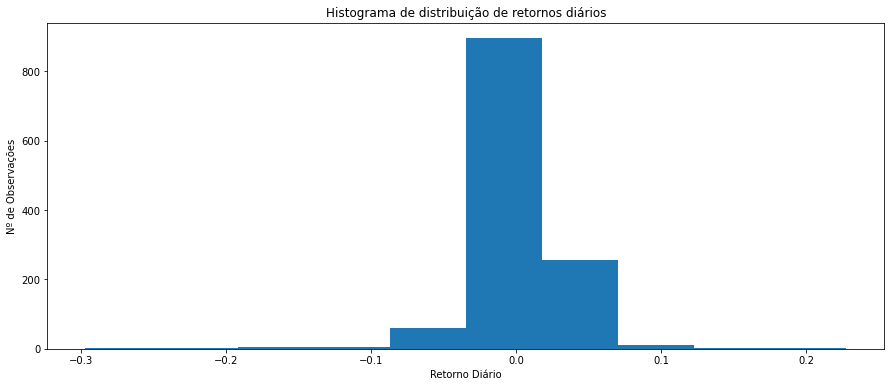

In [159]:
plt.figure(figsize=(15, 6))
plt.title("Histograma de distribuição de retornos diários")
plt.ylabel("Nº de Observações")
plt.xlabel("Retorno Diário")
plt.hist(historical_prices.adjclose["PETR3.SA"].pct_change());

# Var Gaussiano em Décimos

In [161]:
pd.DataFrame({"Var Gauss 95 %" : Erk.var_gaussian(historical_prices.adjclose.pct_change())})

,Var Gauss 95 %
Symbols,
PETR3.SA,0.048079
^BVSP,0.027145


# Informação Contábil --------------------

## Lucro líquido Histórico desde 2015

In [172]:
Financials_Statements(9512, date(2015,1 ,1)).income_acum("Lucro/Prejuízo Consolidado do Período", "itr", 3)

,Lucro/Prejuízo Consolidado do Período
Data,
2014-09-30,-5939000.0
2015-03-31,4528000.0
2015-06-30,908000.0
2015-09-30,-5025000.0
2016-03-31,-381000.0
2016-06-30,899000.0
2016-09-30,-16323000.0
2017-03-31,4807000.0
2017-06-30,292000.0


# Taxa de Crescimento LL, formato decimal

In [165]:
(Financials_Statements(9512, date(2015,1 ,1)).income_acum("Lucro/Prejuízo Consolidado do Período", "itr", 3).pct_change() +  1).prod()

Lucro/Prejuízo Consolidado do Período   -5.257451
dtype: float64

# Plotando Lucro Líquido

In [171]:
ll_historico = Financials_Statements(9512, date(2015,1 ,1)).income_acum("Lucro/Prejuízo Consolidado do Período", "itr", 3)
x = ll_historico.index
y = ll_historico[ll_historico.columns[0]]

In [238]:
ll_historico.index = ll_historico.index.strftime("%Y-%m-%d") 

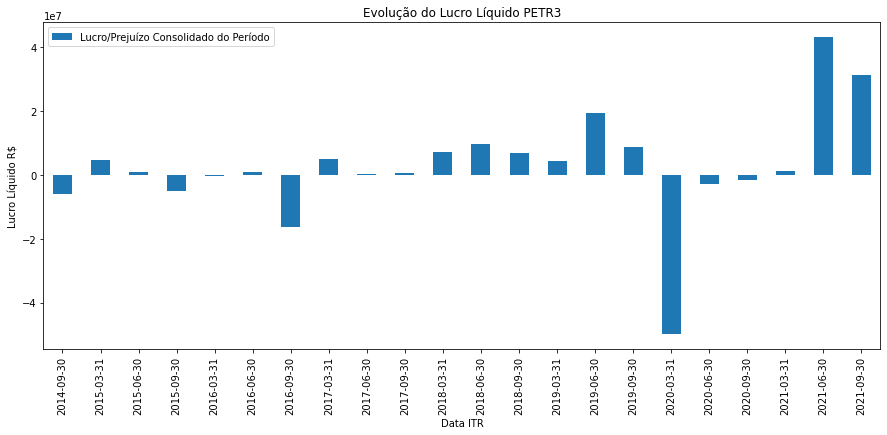

In [253]:
ax = ll_historico.plot.bar(figsize = (15, 6))
ax.set_ylabel("Lucro Líquido R$")
ax.set_xlabel("Data ITR")
ax.set_title("Evolução do Lucro Líquido PETR3");